In [ ]:
#mounting the dataset

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#Extract ZIP File
import zipfile
import os

zip_file_path = "/content/drive/MyDrive/archive.zip"
extract_dir = "/content"

if os.path.exists(zip_file_path):
    try:
        with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
            zip_ref.extractall(extract_dir)
        print(f"Successfully extracted '{zip_file_path}' to '{extract_dir}'")
    except zipfile.BadZipFile:
        print(f"Error: '{zip_file_path}' is not a valid zip file.")
    except Exception as e:
        print(f"An error occurred: {e}")
else:
    print(f"Error: '{zip_file_path}' does not exist.")

Successfully extracted '/content/drive/MyDrive/archive.zip' to '/content'


In [ ]:
#Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import cv2,random

In [ ]:
train_dir = "/content/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/train"
valid_dir = "/content/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/valid"

img_size = 96
batch_size = 32

train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    rotation_range=25,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.15,
    height_shift_range=0.15
)

val_test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_directory(
    train_dir, target_size=(img_size, img_size), batch_size=batch_size,
    class_mode='categorical', shuffle=True)

val_gen = val_test_datagen.flow_from_directory(
    valid_dir, target_size=(img_size, img_size), batch_size=batch_size,
    class_mode='categorical', shuffle=False)

test_gen = val_test_datagen.flow_from_directory(
    valid_dir, target_size=(img_size, img_size), batch_size=batch_size,
    class_mode='categorical', shuffle=False)




Found 70295 images belonging to 38 classes.
Found 17572 images belonging to 38 classes.
Found 17572 images belonging to 38 classes.


In [ ]:
# Continue with class_names list
print("Class indices:")
for class_name, index in train_gen.class_indices.items():
    print(f"{index}: {class_name}")


Class indices:
0: Apple___Apple_scab
1: Apple___Black_rot
2: Apple___Cedar_apple_rust
3: Apple___healthy
4: Blueberry___healthy
5: Cherry_(including_sour)___Powdery_mildew
6: Cherry_(including_sour)___healthy
7: Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot
8: Corn_(maize)___Common_rust_
9: Corn_(maize)___Northern_Leaf_Blight
10: Corn_(maize)___healthy
11: Grape___Black_rot
12: Grape___Esca_(Black_Measles)
13: Grape___Leaf_blight_(Isariopsis_Leaf_Spot)
14: Grape___healthy
15: Orange___Haunglongbing_(Citrus_greening)
16: Peach___Bacterial_spot
17: Peach___healthy
18: Pepper,_bell___Bacterial_spot
19: Pepper,_bell___healthy
20: Potato___Early_blight
21: Potato___Late_blight
22: Potato___healthy
23: Raspberry___healthy
24: Soybean___healthy
25: Squash___Powdery_mildew
26: Strawberry___Leaf_scorch
27: Strawberry___healthy
28: Tomato___Bacterial_spot
29: Tomato___Early_blight
30: Tomato___Late_blight
31: Tomato___Leaf_Mold
32: Tomato___Septoria_leaf_spot
33: Tomato___Spider_mites Two-s

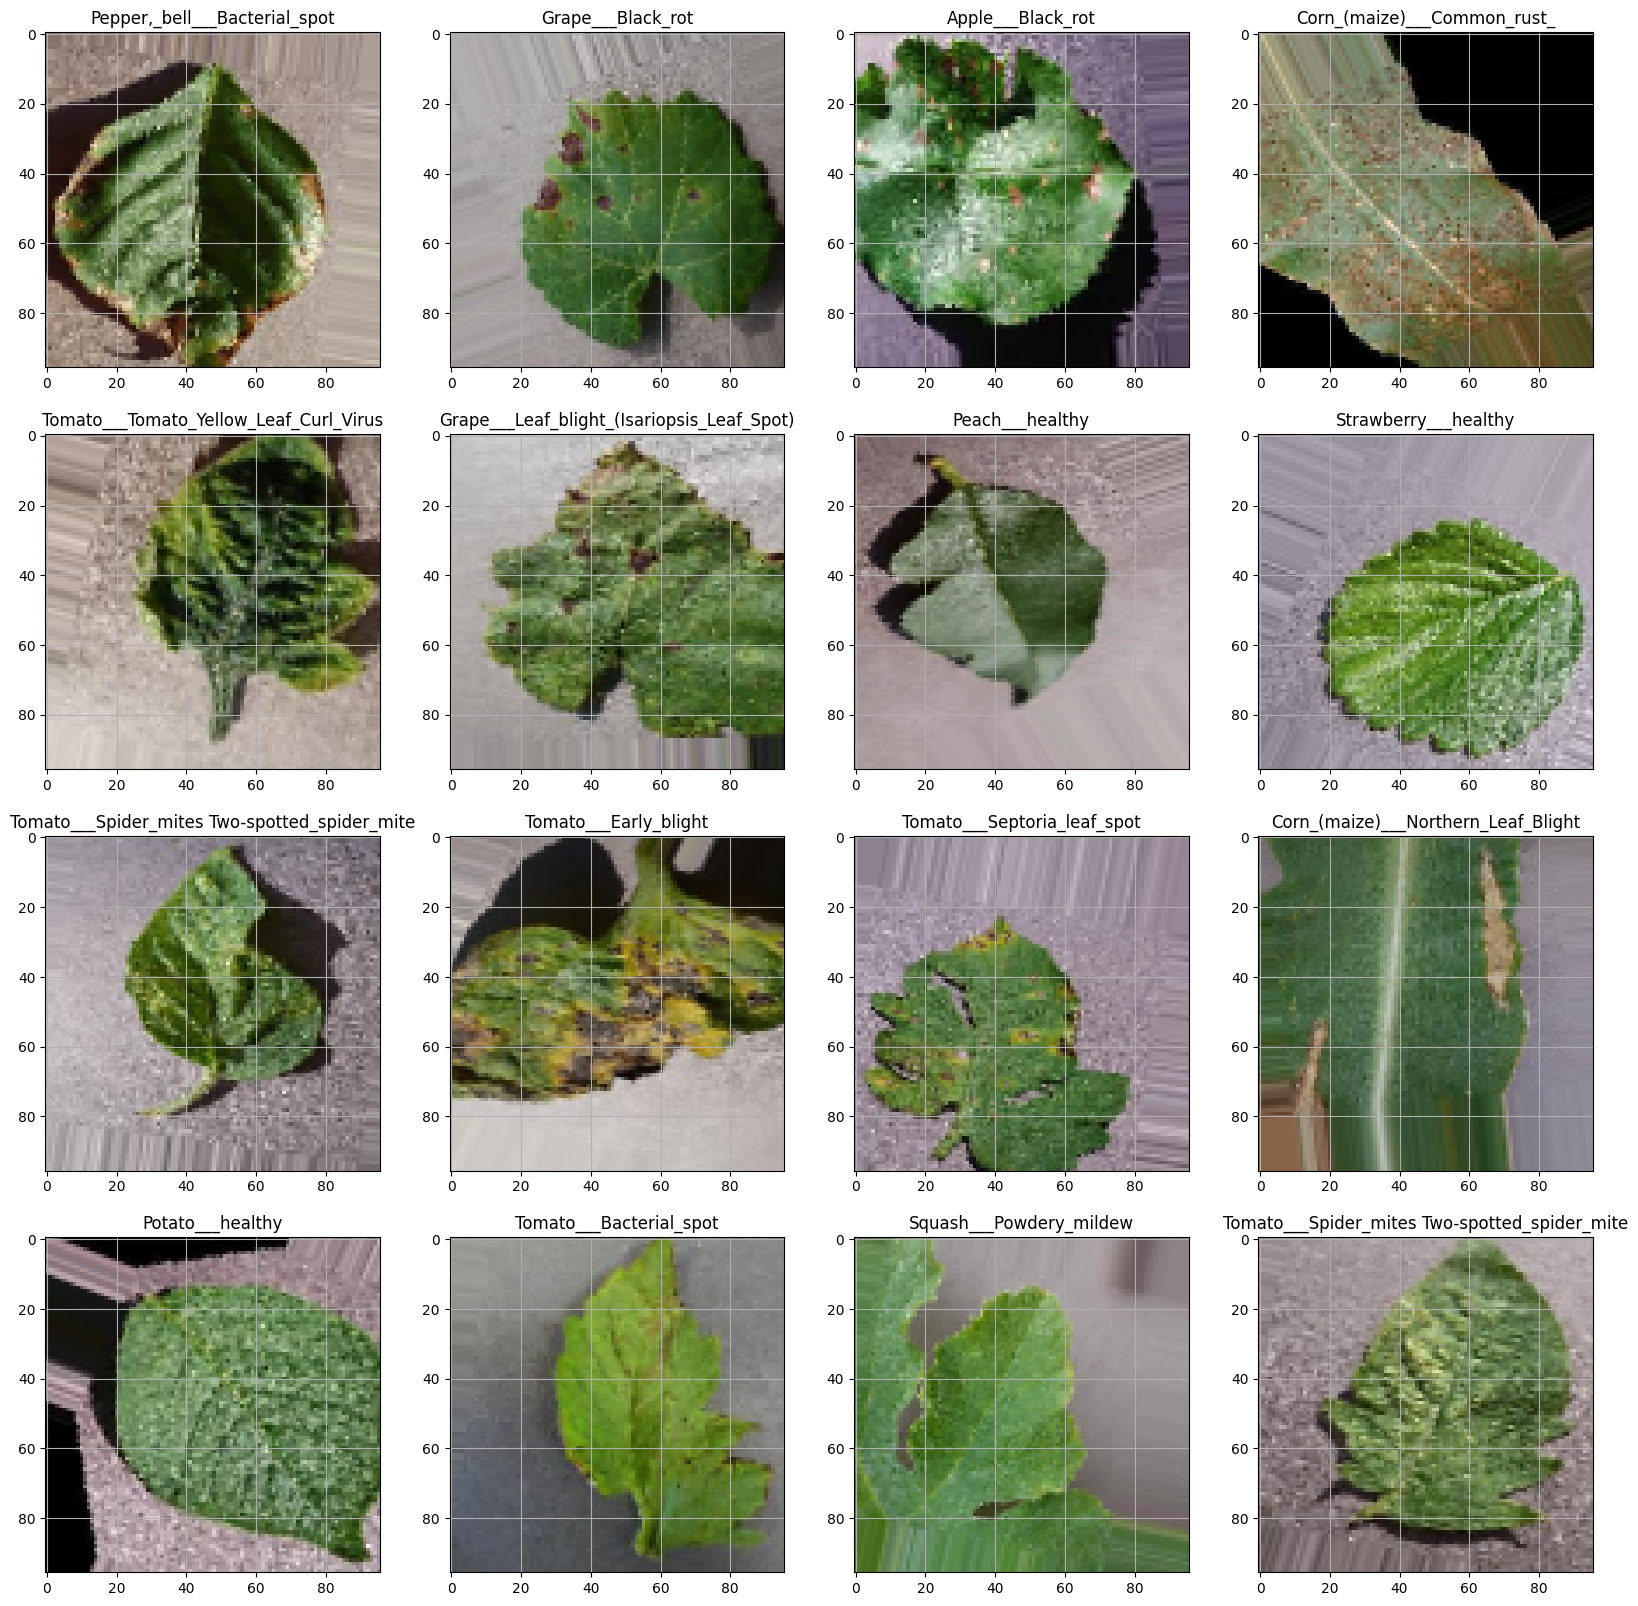

In [ ]:
#Visualize sample images
classes = list(train_gen.class_indices.keys())
plt.figure(figsize=(20, 20))

for X_batch, y_batch in train_gen:
    for i in range(16):
        plt.subplot(4, 4, i + 1)
        plt.imshow(X_batch[i])
        plt.title(classes[np.where(y_batch[i] == 1)[0][0]])  # for one-hot labels
        plt.grid(True)  # grid lines
        plt.axis('on')  # axis ticks
    plt.show()
    break
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy("mixed_float16")




In [ ]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, Input
from tensorflow.keras.optimizers import Adam

# Load MobileNetV2 base
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(img_size, img_size, 3))
base_model.trainable = False  # Freeze base layers

# Add custom layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(len(classes), activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)

# Compile
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy', 'Precision', 'Recall']
)

model.summary()



9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 96, 96, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cast (Cast)         │ (None, 96, 96, 3) │          0 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 48, 48,    │        864 │ cast[0][0]        │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 48, 48,    │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 48, 48,    │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 48, 48,    │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 48, 48,    │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 48, 48,    │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 48, 48,    │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 48, 48,    │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 48, 48,    │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 48, 48,    │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 48, 48,    │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 49, 49,    │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 24, 24,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 24, 24,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 24, 24,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                 

 Total params: 2,426,854 (9.26 MB)

 Trainable params: 168,870 (659.65 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [ ]:
#setting callbacks
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy("mixed_float16")
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=15, min_lr=1e-6)
]


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator


history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=15,  # increased
    steps_per_epoch=len(train_gen)//2,
    validation_steps=len(val_gen),
    callbacks=callbacks
)




Epoch 1/15
1098/1098 ━━━━━━━━━━━━━━━━━━━━ 135s 123ms/step - Precision: 0.8099 - Recall: 0.6157 - accuracy: 0.7015 - loss: 0.9751 - val_Precision: 0.9063 - val_Recall: 0.7457 - val_accuracy: 0.8243 - val_loss: 0.5644 - learning_rate: 0.0010
Epoch 2/15
1098/1098 ━━━━━━━━━━━━━━━━━━━━ 134s 122ms/step - Precision: 0.8086 - Recall: 0.6193 - accuracy: 0.7027 - loss: 0.9582 - val_Precision: 0.9032 - val_Recall: 0.7529 - val_accuracy: 0.8281 - val_loss: 0.5520 - learning_rate: 0.0010
Epoch 3/15
1098/1098 ━━━━━━━━━━━━━━━━━━━━ 17s 15ms/step - Precision: 0.9048 - Recall: 0.5938 - accuracy: 0.7188 - loss: 0.7834 - val_Precision: 0.9039 - val_Recall: 0.7539 - val_accuracy: 0.8293 - val_loss: 0.5487 - learning_rate: 0.0010
Epoch 4/15
1098/1098 ━━━━━━━━━━━━━━━━━━━━ 130s 118ms/step - Precision: 0.8094 - Recall: 0.6267 - accuracy: 0.7093 - loss: 0.9441 - val_Precision: 0.9173 - val_Recall: 0.7536 - val_accuracy: 0.8343 - val_loss: 0.5323 - learning_rate: 0.0010
Epoch 5/15
1098/1098 ━━━━━━━━━━━━━━━━━━━━ 

In [ ]:
#Evaluation
from tensorflow.keras.models import load_model

# Load the saved best model
model = load_model('best_model.keras')

# Evaluate on test data
model_evaluate = model.evaluate(test_gen)
print('Loss: ', model_evaluate[0])
print('Accuracy: ', model_evaluate[1])
print('Precision: ', model_evaluate[2])
print('Recall: ', model_evaluate[3])




550/550 ━━━━━━━━━━━━━━━━━━━━ 25s 35ms/step - Precision: 0.9329 - Recall: 0.8609 - accuracy: 0.9015 - loss: 0.3239
Loss:  0.5062310099601746
Accuracy:  0.8369565010070801
Precision:  0.9071481227874756
Recall:  0.7706009745597839


In [ ]:
# Plot accuracy
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(1, len(acc) + 1)

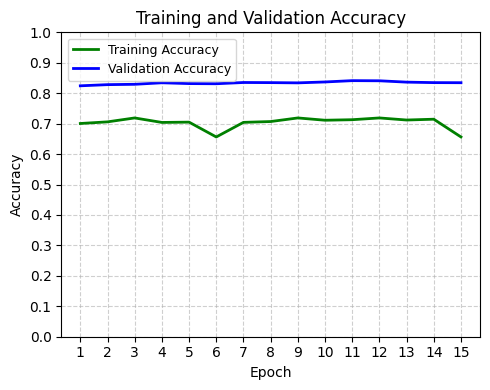

In [ ]:
#visualising the plot
plt.figure(figsize=(5, 4))
plt.plot(epochs, acc, color='green', linewidth=2, label='Training Accuracy')
plt.plot(epochs, val_acc, color='blue', linewidth=2, label='Validation Accuracy')
plt.title('Training and Validation Accuracy', fontsize=12)
plt.xlabel('Epoch', fontsize=10)
plt.ylabel('Accuracy', fontsize=10)
plt.xticks(epochs)
plt.yticks([i/10 for i in range(0, 11)])
plt.ylim(0, 1.0)
plt.legend(fontsize=9)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


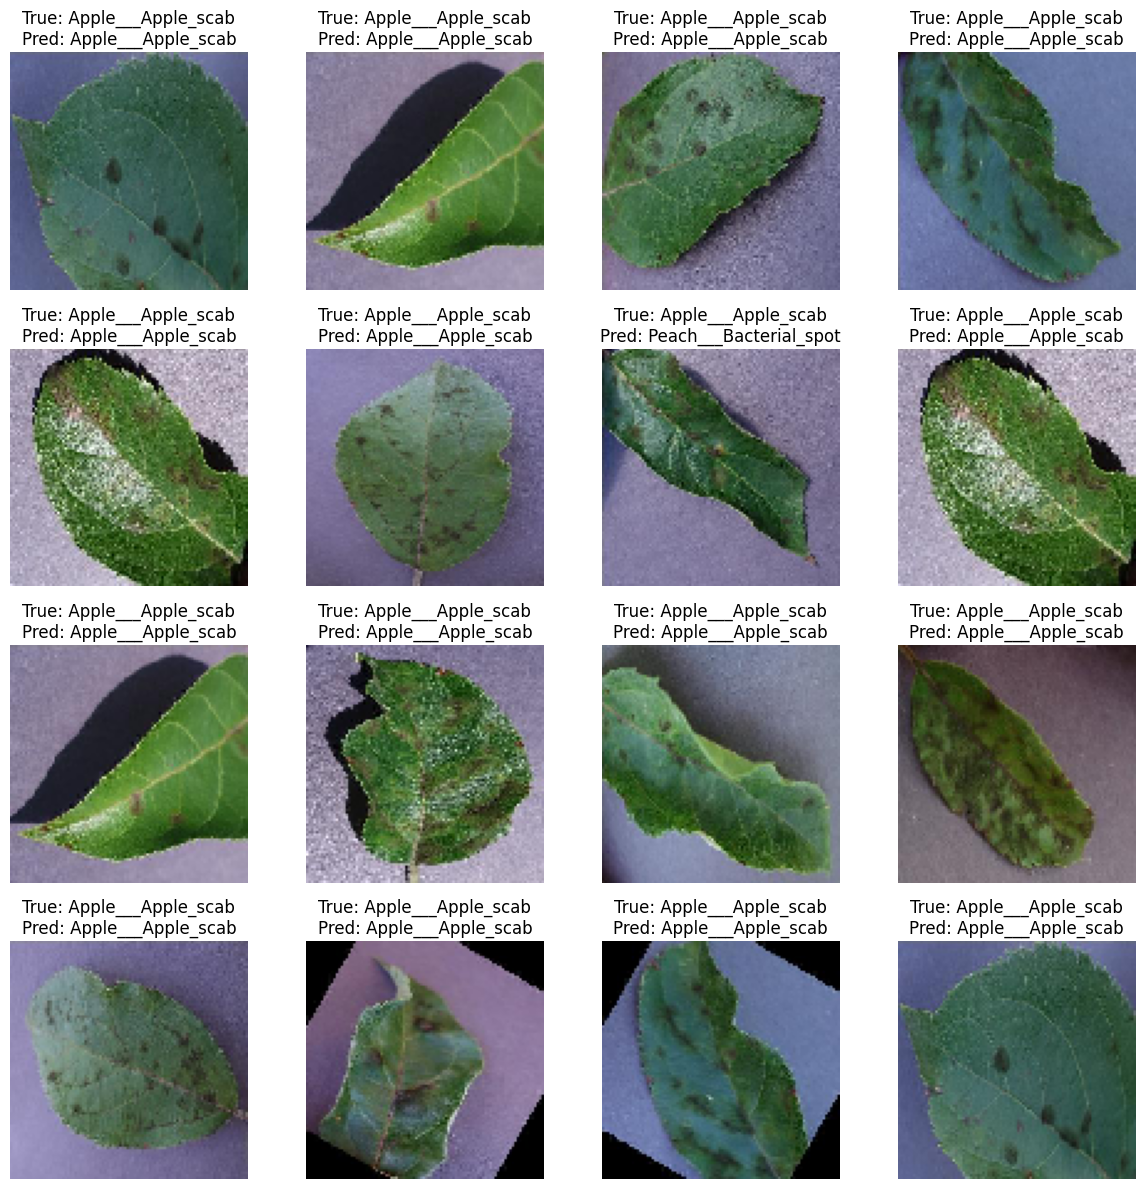

In [ ]:
#Predict on some test images
x_test, y_test = next(test_gen)
y_pred = np.argmax(model.predict(x_test), axis=1)
y_true = np.argmax(y_test, axis=1)

plt.figure(figsize=(12, 12))
for i in range(16):
    idx = random.randint(0, len(x_test)-1)
    plt.subplot(4, 4, i+1)
    plt.imshow(x_test[idx])
    plt.title(f"True: {classes[y_true[idx]]}\nPred: {classes[y_pred[idx]]}")
    plt.axis('off')
plt.tight_layout()
plt.show()


In [ ]:
# TO save the model
model.save('PDDS.keras')